In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from models.spiking_layers import LinearLIF, Conv2dLIF
from models.spiking_models import SpikingModel
from models.conversion_method import spike_norm
from utils.metrics import timesteps_performance, test
from utils.dataloader import load_data
import matplotlib.pyplot as plt
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
train_loader, test_loader, classes_labels = load_data()

Files already downloaded and verified
Files already downloaded and verified


## VGG5 model

In [3]:
class VGG5(nn.Module):
    def __init__(self):
        super(VGG5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=8192, out_features=1024, bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=1024, out_features=1024, bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=1024, out_features=10, bias=False),
        )

    def forward(self, input):
        batch_size = input.shape[0]
        x = self.features(input)
        x = x.view(batch_size, -1)
        x = self.classifier(x)
        return x

ann_model = VGG5()
ann_model.load_state_dict(torch.load("../pre_trained_models/CANN_VGG5_CIFAR10.pth"))
ann_model.to(DEVICE)
ann_loss, ann_acc = test(ann_model, "VGG5", test_loader)

Test result on VGG5: Avg loss is 0.3297829836845398, Accuracy: 89.31999969482422%


## Spiking VGG5 with Soft-Reset

In [4]:
features = nn.Sequential(
        Conv2dLIF(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
        nn.ReLU(inplace=True),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
        Conv2dLIF(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        Conv2dLIF(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
        nn.ReLU(inplace=True),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        )

classifier = nn.Sequential(
        LinearLIF(in_features=8192, out_features=1024, bias=False),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        LinearLIF(in_features=1024, out_features=1024, bias=False),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        LinearLIF(in_features=1024, out_features=10, bias=False)
        )
timesteps = 100
snn_sr_model = SpikingModel(features, classifier, timesteps, device=DEVICE)
snn_sr_model.to(DEVICE)
snn_sr_model.load_state_dict(torch.load("../pre_trained_models/SNN_SR_VGG5_100ts.pth"))

<All keys matched successfully>

In [ ]:
snn_sr_loss, snn_sr_acc = test(snn_sr_model, "Spiking VGG5 before conversion", test_loader)

## ANN to SNN Conversion

In [10]:
snn_sr_model = spike_norm(ann_model, snn_sr_model, train_loader, DEVICE, timesteps)



 Missing keys : ['features.0.leak', 'features.0.threshold', 'features.3.leak', 'features.3.threshold', 'features.6.leak', 'features.6.threshold', 'classifier.0.leak', 'classifier.0.threshold', 'classifier.3.leak', 'classifier.3.threshold', 'classifier.6.leak', 'classifier.6.threshold']
 Unexpected Keys: []
Conv2dLIF(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Threshold: 22.955711364746094
Conv2dLIF(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Threshold: 2.2671780586242676
Conv2dLIF(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Threshold: 1.6751294136047363
LinearLIF(
  in_features=8192, 
  out_features=1024, 
  bias=False, 
  leak=1.0, 
  threshold=0.3358011245727539
)
Threshold: 0.3358011245727539
LinearLIF(
  in_features=1024, 
  out_features=1024, 
  bias=False, 
  leak=1.0, 
  threshold=0.47430211305618286
)
Threshold: 0.47430211305618286
LinearLIF(
  in_features=1024, 
  out_features=10, 
  bias=False

In [ ]:
snn_sr_loss, snn_sr_acc = test(snn_sr_model, "Spiking VGG5 after conversion", test_loader)

In [11]:
torch.save(snn_sr_model.state_dict(), "../pre_trained_models/SNN_SR_VGG5_100ts.pth")
# Saving SNN SR model

## Spiking VGG5 with Hard-Reset

In [5]:
features = nn.Sequential(
        Conv2dLIF(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, reset="hard"),
        nn.ReLU(inplace=True),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
        Conv2dLIF(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, reset="hard"),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        Conv2dLIF(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, reset="hard"),
        nn.ReLU(inplace=True),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        )

classifier = nn.Sequential(
        LinearLIF(in_features=8192, out_features=1024, bias=False, reset="hard"),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        LinearLIF(in_features=1024, out_features=1024, bias=False, reset="hard"),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        LinearLIF(in_features=1024, out_features=10, bias=False, reset="hard")
        )
timesteps = 100
snn_hr_model = SpikingModel(features, classifier, timesteps, device=DEVICE)
snn_hr_model.to(DEVICE)
snn_hr_model.load_state_dict(torch.load("../pre_trained_models/SNN_HR_VGG5_100ts.pth"))

<All keys matched successfully>

In [ ]:
snn_hr_loss, snn_hr_acc = test(snn_hr_model, "Spiking VGG5 before conversion", test_loader)

## ANN to SNN Conversion

In [13]:
snn_hr_model = spike_norm(ann_model, snn_hr_model, train_loader, DEVICE, timesteps)


 Missing keys : ['features.0.leak', 'features.0.threshold', 'features.3.leak', 'features.3.threshold', 'features.6.leak', 'features.6.threshold', 'classifier.0.leak', 'classifier.0.threshold', 'classifier.3.leak', 'classifier.3.threshold', 'classifier.6.leak', 'classifier.6.threshold']
 Unexpected Keys: []
Conv2dLIF(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Threshold: 22.955711364746094
Conv2dLIF(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Threshold: 3.022050619125366
Conv2dLIF(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Threshold: 2.204780340194702
LinearLIF(
  in_features=8192, 
  out_features=1024, 
  bias=False, 
  leak=1.0, 
  threshold=0.28566956520080566
)
Threshold: 0.28566956520080566
LinearLIF(
  in_features=1024, 
  out_features=1024, 
  bias=False, 
  leak=1.0, 
  threshold=0.4563365578651428
)
Threshold: 0.4563365578651428
LinearLIF(
  in_features=1024, 
  out_features=10, 
  bias=False, 

In [14]:
snn_hr_loss, snn_hr_acc = test(snn_hr_model, "Spiking VGG5 after conversion", test_loader)

Test result on Spiking VGG5 after conversion: Avg loss is 2.2204186897277833, Accuracy: 20.5%


In [15]:
torch.save(snn_hr_model.state_dict(), "../pre_trained_models/SNN_HR_VGG5_100ts.pth")
# Saving SNN SR model

## Performance with number of timesteps

In [ ]:
num_timesteps = [10, 20, 30, 40, 50, 100, 200, 300]

acc_list = []
for scaling_factor in [1, 0.8, 0.6, 0.4, 0.2]:
    _, acc_factor = timesteps_performance(snn_hr_model, test_loader, num_timesteps, scaling_factor)
    acc_list.append(acc_factor)

scales = [1, 0.8, 0.6, 0.4, 0.2]
fig = plt.figure("Acc vs Timesteps")
plt.plot([ann_acc]*len(num_timesteps), "-o")
for k in range(5):
    plt.plot(acc_list[k], "-o")
plt.legend(["ANN", "SNN Vth", "SNN Vth*0.8", "SNN Vth*0.6", "SNN Vth*0.4", "SNN Vth*0.2"])
plt.xlabel("No. Timesteps")
plt.ylabel("Accuracy")
plt.xticks(range(8), [str(k) for k in num_timesteps])
plt.grid(True)
plt.show()

In [ ]:
image_format = 'png'  # e.g .png, .svg, etc.
image_name = 'vgg5_snn_sr_acc_timesteps.png'
fig.savefig(image_name, format=image_format, dpi=1200)

## Performance with number of timesteps

Test result on Timesteps=10: Avg loss is 2.302584887313843, Accuracy: 10.0%
Test result on Timesteps=20: Avg loss is 2.302584887313843, Accuracy: 10.0%
Test result on Timesteps=30: Avg loss is 2.30226982383728, Accuracy: 10.019999504089355%
Test result on Timesteps=40: Avg loss is 2.293812719345093, Accuracy: 10.809999465942383%
Test result on Timesteps=50: Avg loss is 2.2657479942321777, Accuracy: 13.880000114440918%
Test result on Timesteps=100: Avg loss is 2.1967223617553713, Accuracy: 38.36000061035156%
Test result on Timesteps=200: Avg loss is 3.187659564971924, Accuracy: 30.299999237060547%
Test result on Timesteps=300: Avg loss is 3.2479029956817627, Accuracy: 29.279998779296875%
Test result on Timesteps=10: Avg loss is 2.302584887313843, Accuracy: 10.0%
Test result on Timesteps=20: Avg loss is 2.293670006942749, Accuracy: 10.789999961853027%
Test result on Timesteps=30: Avg loss is 2.166909951400757, Accuracy: 19.920000076293945%
Test result on Timesteps=40: Avg loss is 2.09692

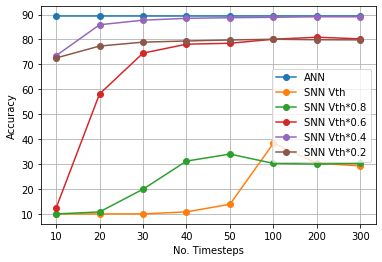

In [9]:
num_timesteps = [10, 20, 30, 40, 50, 100, 200, 300]

acc_list = []
scales = [1, 0.8, 0.6, 0.4, 0.2]
for scaling_factor in scales:
    _, acc_factor = timesteps_performance(snn_sr_model, test_loader, num_timesteps, scaling_factor)
    acc_list.append(acc_factor)

fig = plt.figure("Acc vs Timesteps")
plt.plot([ann_acc]*len(num_timesteps), "-o")
for k in range(len(scales)):
    plt.plot(acc_list[k], "-o")
plt.legend(["ANN", "SNN Vth", "SNN Vth*0.8", "SNN Vth*0.6", "SNN Vth*0.4", "SNN Vth*0.2"])
plt.xlabel("No. Timesteps")
plt.ylabel("Accuracy")
plt.xticks(range(8), [str(k) for k in num_timesteps])
plt.grid(True)
plt.show()

In [11]:
image_format = 'svg'  # e.g .png, .svg, etc.
image_name = 'vgg5_snn_sr_acc_timesteps.svg'
fig.savefig(image_name, format=image_format, dpi=1200)

In [12]:
import numpy as np
np.save("acc_snn_vgg5_sr.npy", np.array(acc_list))

